# Imports

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

In [ ]:
files.upload()

Saving rev100.csv to rev100.csv


{'rev100.csv': b',Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,text\r\n0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.\r\n1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."\r\n2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into t

In [ ]:
data = pd.read_csv("rev100.csv")
data.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
data = data.rename({'Text': 'text'}, axis=1)  

In [ ]:
df = data[['text']]
df['text'] = df['text'].astype(str)
df.head()

,text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


# Preprocessing

## Lowercasing

Idea is to convert all texts into the same format so that two same words with lower/upper letters would not be dublicated in word representations. Especially helps when we use frequence and TF-IDF based algorithms to get the correct count and TF-IDF values. However, most of the modern libraries already includes lowercasing in their packages. (We need to set is to False if we actually want to do it.)

In [ ]:
df['low_text'] = df['text'].str.lower()
df.head()

,text,low_text
0,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,This is a confection that has been around a fe...,this is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...,great taffy at a great price. there was a wid...


## Removing Punctuations

Removal of punctuations and symbols is another necessary text preprocessing in text summarization. (We do not need to identify the difference between "Bad" and "Bad!!!", since we are doing text summarization). Therefore, we need to remove those symbols such as exclamation and question marks, and other signs as well. Those are below:

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Example
SYMBOLS = string.punctuation
text = "Hello, Northeastern! How are you today?"
print(text.translate(str.maketrans('', '', SYMBOLS)))

Hello Northeastern How are you today


In [ ]:
# Function
SYMBOLS = string.punctuation
def clean_symbols(text):
  return text.translate(str.maketrans('', '', SYMBOLS))

In [ ]:
# df.drop(['text'], axis = 1, inplace=True)
df['no_symbol'] = df['low_text'].apply(lambda text: clean_symbols(text))
df

,text,low_text,no_symbol
0,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,i have bought several of the vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,product arrived labeled as jumbo salted peanut...
2,This is a confection that has been around a fe...,this is a confection that has been around a fe...,this is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...,great taffy at a great price. there was a wid...,great taffy at a great price there was a wide...
...,...,...,...
95,I've been very pleased with the Natural Balanc...,i've been very pleased with the natural balanc...,ive been very pleased with the natural balance...
96,My 1-1/2 year old basenji/jack russell mix lov...,my 1-1/2 year old basenji/jack russell mix lov...,my 112 year old basenjijack russell mix loves ...
97,Our pup has experienced allergies in forms of ...,our pup has experienced allergies in forms of ...,our pup has experienced allergies in forms of ...
98,My English Bulldog had skin allergies the summ...,my english bulldog had skin allergies the summ...,my english bulldog had skin allergies the summ...


## Stopwords Removal

We should also remove stopwords from the collection as they are most commonly occuring words in the corpora, whilst not holding significant value in the context. To not give stopwords high weight because of their high frequency, we remove them from the list wholly. NLTK library correctly identifies almost all of the stopwords from the collection of 23 different languages from russian to even azerbaijani

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
" ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


"i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his himself she she's her hers herself it it's its itself they them their theirs themselves what which who whom this that that'll these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don don't should should've now d ll m o re ve y ain aren aren't couldn couldn't didn didn't doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn shouldn't wasn wasn't weren weren't won won't wouldn wouldn't"

In [ ]:
STOPS = set(stopwords.words("english"))
def clean_stops(text):
  return " ".join([word for word in str(text).split() if word not in STOPS])

df['no_stop'] = df['no_symbol'].apply(lambda text: clean_stops(text))
df.head()

,text,low_text,no_symbol,no_stop
0,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,i have bought several of the vitality canned d...,bought several vitality canned dog food produc...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,product arrived labeled as jumbo salted peanut...,product arrived labeled jumbo salted peanutsth...
2,This is a confection that has been around a fe...,this is a confection that has been around a fe...,this is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,great taffy at a great price. there was a wid...,great taffy at a great price there was a wide...,great taffy great price wide assortment yummy ...


## Frequent Word Removal

[link text](https://)Apart from the stopwords, there might be further genuinely frequent words in a domain specific corpora which would not hold any value for the whole dataset. So, we also need to identify those words and clean our data.

In [ ]:
from collections import Counter
cnt = Counter()

for text in df['no_stop']:
  for word in text.split():
    cnt[word] += 1
# See most common ten words
cnt.most_common(10)

[('food', 53),
 ('good', 41),
 ('like', 36),
 ('dog', 33),
 ('br', 33),
 ('oatmeal', 28),
 ('great', 27),
 ('product', 22),
 ('taste', 22),
 ('one', 21)]

In [ ]:
set(word for (word, frequency) in cnt.most_common(10))
MOST_COMMON = set(word for (word, frequency) in cnt.most_common(10))

In [ ]:
def clean_common(text):
  return " ".join([word for word in str(text).split() if word not in MOST_COMMON])

df['no_common'] = df['no_stop'].apply(lambda text: clean_common(text))
df.head()

,text,low_text,no_symbol,no_stop,no_common
0,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,i have bought several of the vitality canned d...,bought several vitality canned dog food produc...,bought several vitality canned products found ...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,product arrived labeled as jumbo salted peanut...,product arrived labeled jumbo salted peanutsth...,arrived labeled jumbo salted peanutsthe peanut...
2,This is a confection that has been around a fe...,this is a confection that has been around a fe...,this is a confection that has been around a fe...,confection around centuries light pillowy citr...,confection around centuries light pillowy citr...
3,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,great taffy at a great price. there was a wid...,great taffy at a great price there was a wide...,great taffy great price wide assortment yummy ...,taffy price wide assortment yummy taffy delive...


## Rare Word Removal

On the one hand, most frequent words do not give any valuable information to the model. While, on the other hand, rare words not any yet to hold insignificant value, but also may possibly mislead the model. Therefore, we will go ahead and remove those as well as a preprocessing step

In [ ]:
set([w for (w, wc) in cnt.most_common()[:-10-1:-1]])
LEAST_COMMON = set([word for (word, frequency) in cnt.most_common()[:-11:-1]])

In [ ]:
def clean_rare(text):
  return " ".join([word for word in str(text).split() if word not in LEAST_COMMON])

df['no_rare'] = df['no_common'].apply(lambda text: clean_rare(text))
df.head()

,text,low_text,no_symbol,no_stop,no_common,no_rare
0,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,i have bought several of the vitality canned d...,bought several vitality canned dog food produc...,bought several vitality canned products found ...,bought several vitality canned products found ...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,product arrived labeled as jumbo salted peanut...,product arrived labeled jumbo salted peanutsth...,arrived labeled jumbo salted peanutsthe peanut...,arrived labeled jumbo salted peanutsthe peanut...
2,This is a confection that has been around a fe...,this is a confection that has been around a fe...,this is a confection that has been around a fe...,confection around centuries light pillowy citr...,confection around centuries light pillowy citr...,confection around centuries light pillowy citr...
3,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,looking secret ingredient robitussin believe f...,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,great taffy at a great price. there was a wid...,great taffy at a great price there was a wide...,great taffy great price wide assortment yummy ...,taffy price wide assortment yummy taffy delive...,taffy price wide assortment yummy taffy delive...


### Remove unnecessary features

In [ ]:
df.drop(['low_text', 'no_symbol', 'no_stop', 'no_common'], axis = 1, inplace=True)

In [ ]:
df.head()

,text,no_rare
0,I have bought several of the Vitality canned d...,bought several vitality canned products found ...
1,Product arrived labeled as Jumbo Salted Peanut...,arrived labeled jumbo salted peanutsthe peanut...
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,taffy price wide assortment yummy taffy delive...


## Stemming

Stemming is a process of deriving the root of the word from previously transformed word.It is basically removing whatever the extra part comes after the word itself. Just like, remove "ing" from the word "going".

In [ ]:
# We are using the SnowBall stemmer as it can also be used to stem words from different languages up to the number of 16 most known ones.
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')
SnowballStemmer.languages

('arabic',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'hungarian',
 'italian',
 'norwegian',
 'porter',
 'portuguese',
 'romanian',
 'russian',
 'spanish',
 'swedish')

In [ ]:
def stem(text):
  return " ".join([stemmer.stem(word) for word in text.split()])

df['stemmed'] = df['no_rare'].apply(lambda text: stem(text))
df.head()

,text,no_rare,stemmed
0,I have bought several of the Vitality canned d...,bought several vitality canned products found ...,bought sever vital can product found qualiti l...
1,Product arrived labeled as Jumbo Salted Peanut...,arrived labeled jumbo salted peanutsthe peanut...,arriv label jumbo salt peanutsth peanut actual...
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,confect around centuri light pillowi citrus ge...
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,look secret ingredi robitussin believ found go...
4,Great taffy at a great price. There was a wid...,taffy price wide assortment yummy taffy delive...,taffi price wide assort yummi taffi deliveri q...


## Lemmatization

Lemmatization is also one of the options to preprocess as it recovers the root of the word if the word had already been transformed into another form. It works perfectly whenever we provide the Part of Speech Tag of each word, so that it identifies to recover to noun, verb, or adjective root

In [ ]:
## Requirements: wordnet corpora to use Lemmatizer
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmar = WordNetLemmatizer()
def lemmatizer(text):
  return " ".join([lemmar.lemmatize(word) for word in text.split()])

df['lemmatized'] = df['no_rare'].apply(lambda text: lemmatizer(text))
df.head()

,text,no_rare,stemmed,lemmatized
0,I have bought several of the Vitality canned d...,bought several vitality canned products found ...,bought sever vital can product found qualiti l...,bought several vitality canned product found q...
1,Product arrived labeled as Jumbo Salted Peanut...,arrived labeled jumbo salted peanutsthe peanut...,arriv label jumbo salt peanutsth peanut actual...,arrived labeled jumbo salted peanutsthe peanut...
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,confect around centuri light pillowi citrus ge...,confection around century light pillowy citrus...
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,look secret ingredi robitussin believ found go...,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,taffy price wide assortment yummy taffy delive...,taffi price wide assort yummi taffi deliveri q...,taffy price wide assortment yummy taffy delive...


## Removing emojis from text

While emojis hold some information about the expression of a customer, in our textual analysis, we will not need them. Thus, we remove emojis as well. 
Source: [Source Code Github](https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b). 

Thanks to this Github repo, we can potentially convert emojies and emoticons to words as well. : [Git](https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py)

In [ ]:
def remove_emoji(string):
  emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', string)

In [ ]:
remove_emoji("😂🔥 is fire on🔥")

' is fire on'

In [ ]:
df['lemma_no_emoji'] = df['lemmatized'].apply(lambda text: remove_emoji(text))
df.head()

,text,no_rare,stemmed,lemmatized,lemma_no_emoji
0,I have bought several of the Vitality canned d...,bought several vitality canned products found ...,bought sever vital can product found qualiti l...,bought several vitality canned product found q...,bought several vitality canned product found q...
1,Product arrived labeled as Jumbo Salted Peanut...,arrived labeled jumbo salted peanutsthe peanut...,arriv label jumbo salt peanutsth peanut actual...,arrived labeled jumbo salted peanutsthe peanut...,arrived labeled jumbo salted peanutsthe peanut...
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,confect around centuri light pillowi citrus ge...,confection around century light pillowy citrus...,confection around century light pillowy citrus...
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,look secret ingredi robitussin believ found go...,looking secret ingredient robitussin believe f...,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,taffy price wide assortment yummy taffy delive...,taffi price wide assort yummi taffi deliveri q...,taffy price wide assortment yummy taffy delive...,taffy price wide assortment yummy taffy delive...


## Word Count and Cloud

We also add count of words in each review and made word cloud to see the mostly used words in a typical review on Amazon

In [ ]:
df['word_count'] = df['lemma_no_emoji'].apply(lambda x: len(str(x).split(" ")))
df[['text','word_count']].head(5)

,text,word_count
0,I have bought several of the Vitality canned d...,17
1,Product arrived labeled as Jumbo Salted Peanut...,16
2,This is a confection that has been around a fe...,40
3,If you are looking for the secret ingredient i...,17
4,Great taffy at a great price. There was a wid...,11


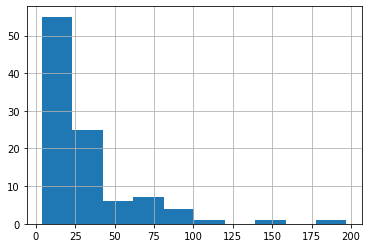

In [ ]:
# Let us take a look at distribution of words in each tweet
df.lemma_no_emoji.str.split().\
    map(lambda x: len(x)).\
    hist()

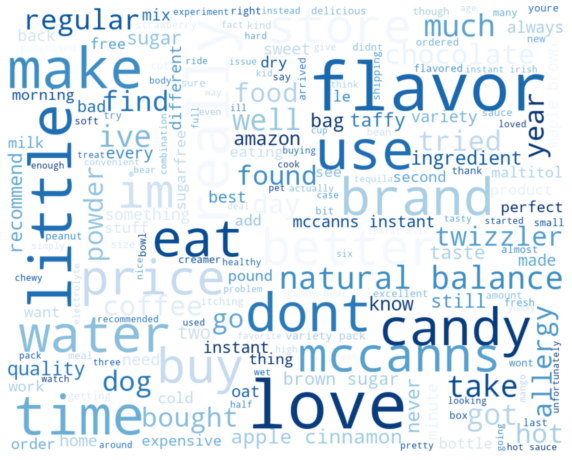

In [ ]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'Blues', 
                       margin = 0,
                       max_words = 200,  
                      #  min_word_length = 4,
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(df['lemma_no_emoji']))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

# Summarization

## Example

In [ ]:
# Took a random long review to make a simple frequency based summarization
df['text'][96]

'My 1-1/2 year old basenji/jack russell mix loves this dog food. He\'s been noticeably healthier and more energetic since I switched him over from the standard dog foods earlier this year. Despite the higher cost of natural dog foods, I find that he eats significantly less of the Natural Balance dog foods and still stays happy and full. On the normal dog foods, he\'d eat up to 3 cups of dog food a day (the recommended serving for his size), whereas he only eats about 1 cup to 1-1/2 cup of the Natural Balance dog food a day. When you take this into account, you\'re actually getting more "bang for your buck" with the natural dog foods since you don\'t have to buy as much to last just as long as the normal dog foods... and a healthier, happier dog, to boot! Add in the fact that you can get free, 2-day shipping with Amazon Prime... I\'m sold!!'

In [ ]:
review = """
My 1-1/2 year old basenji/jack russell mix loves this dog food. He's been noticeably healthier and more energetic 
since I switched him over from the standard dog foods earlier this year. Despite the higher cost of natural dog foods, I find that 
he eats significantly less of the Natural Balance dog foods and still stays happy and full. On the normal dog foods, he'd eat up to 3 cups of dog food a day 
(the recommended serving for his size), whereas he only eats about 1 cup to 1-1/2 cup of the Natural Balance dog food a day. When you take this into account, 
you're actually getting more "bang for your buck" with the natural dog foods since you don't have to buy as much to last just as long as the normal dog foods... 
and a healthier, happier dog, to boot! Add in the fact that you can get free, 2-day shipping with Amazon Prime... I'm sold!"""

## Tokenization

Used NLTK's tokenizer to split the review into sentences

In [ ]:
nltk.download('punkt')
sentence_list = nltk.sent_tokenize(review)
sentence_list

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['\nMy 1-1/2 year old basenji/jack russell mix loves this dog food.',
 "He's been noticeably healthier and more energetic \nsince I switched him over from the standard dog foods earlier this year.",
 'Despite the higher cost of natural dog foods, I find that \nhe eats significantly less of the Natural Balance dog foods and still stays happy and full.',
 "On the normal dog foods, he'd eat up to 3 cups of dog food a day \n(the recommended serving for his size), whereas he only eats about 1 cup to 1-1/2 cup of the Natural Balance dog food a day.",
 'When you take this into account, \nyou\'re actually getting more "bang for your buck" with the natural dog foods since you don\'t have to buy as much to last just as long as the normal dog foods... \nand a healthier, happier dog, to boot!',
 'Add in the fact that you can get free, 2-day shipping with Amazon Prime...',
 "I'm sold!"]

In [ ]:
article_text = re.sub(r'\s+', ' ', review)

In [ ]:
# Removing characters, brackets and digits
formatted_article_text = re.sub('[^a-zA-Z]', ' ', article_text )
formatted_article_text = re.sub(r'\s+', ' ', formatted_article_text)

In [ ]:
sentence_list = nltk.sent_tokenize(article_text)

## Frequency based BoG

Since I am still in the learning process of deeper models, such as LSTM, Seq2Seq, for now, I am only including this Bag of Words model where the summarization is decided upon the weights of words and corresponding sentences. Basically, we calculate the frequency of each word in the review and give a higer weight to the word which has higher occurance. Eventually, we add up the calculated weights of those words to the sentences. As a last step, higher the sum of weights -> We select that sentence to be included in the summary.

In [ ]:

stopwords = nltk.corpus.stopwords.words('english')

word_frequencies = {}
for word in nltk.word_tokenize(formatted_article_text):
    if word not in stopwords:
        if word not in word_frequencies.keys():
            word_frequencies[word] = 1
        else:
            word_frequencies[word] += 1

In [ ]:
maximum_frequncy = max(word_frequencies.values())

for word in word_frequencies.keys():
    word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

In [ ]:
sentence_scores = {}
for sent in sentence_list:
    for word in nltk.word_tokenize(sent.lower()):
        if word in word_frequencies.keys():
            if len(sent.split(' ')) < 30:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_frequencies[word]
                else:
                    sentence_scores[sent] += word_frequencies[word]

In [ ]:
import heapq
summary_sentences = heapq.nlargest(1, sentence_scores, key=sentence_scores.get)

summary = ' '.join(summary_sentences)
print(summary)

Despite the higher cost of natural dog foods, I find that he eats significantly less of the Natural Balance dog foods and still stays happy and full.


In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
!pwd

/content


In [ ]:
!jupyter nbconvert --to pdf /content/Text\ Preprocessing\ and\ BoW.ipynb

## TF-IDF

In [ ]:
formatted_article_text

' My year old basenji jack russell mix loves this dog food He s been noticeably healthier and more energetic since I switched him over from the standard dog foods earlier this year Despite the higher cost of natural dog foods I find that he eats significantly less of the Natural Balance dog foods and still stays happy and full On the normal dog foods he d eat up to cups of dog food a day the recommended serving for his size whereas he only eats about cup to cup of the Natural Balance dog food a day When you take this into account you re actually getting more bang for your buck with the natural dog foods since you don t have to buy as much to last just as long as the normal dog foods and a healthier happier dog to boot Add in the fact that you can get free day shipping with Amazon Prime I m sold '

In [ ]:
text = formatted_article_text

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
sentences = sent_tokenize("""Those Who Are Resilient Stay In The Game Longer
“On the mountains of truth you can never climb in vain: either you will reach a point higher up today, or you will be training your powers so that you will be able to climb higher tomorrow.” — Friedrich Nietzsche
Challenges and setbacks are not meant to defeat you, but promote you. However, I realise after many years of defeats, it can crush your spirit and it is easier to give up than risk further setbacks and disappointments. Have you experienced this before? To be honest, I don’t have the answers. I can’t tell you what the right course of action is; only you will know. However, it’s important not to be discouraged by failure when pursuing a goal or a dream, since failure itself means different things to different people. To a person with a Fixed Mindset failure is a blow to their self-esteem, yet to a person with a Growth Mindset, it’s an opportunity to improve and find new ways to overcome their obstacles. Same failure, yet different responses. Who is right and who is wrong? Neither. Each person has a different mindset that decides their outcome. Those who are resilient stay in the game longer and draw on their inner means to succeed.
I’ve coached many clients who gave up after many years toiling away at their respective goal or dream. It was at that point their biggest breakthrough came. Perhaps all those years of perseverance finally paid off. It was the 19th Century’s minister Henry Ward Beecher who once said: “One’s best success comes after their greatest disappointments.” No one knows what the future holds, so your only guide is whether you can endure repeated defeats and disappointments and still pursue your dream. Consider the advice from the American academic and psychologist Angela Duckworth who writes in Grit: The Power of Passion and Perseverance: “Many of us, it seems, quit what we start far too early and far too often. Even more than the effort a gritty person puts in on a single day, what matters is that they wake up the next day, and the next, ready to get on that treadmill and keep going.”
I know one thing for certain: don’t settle for less than what you’re capable of, but strive for something bigger. Some of you reading this might identify with this message because it resonates with you on a deeper level. For others, at the end of their tether the message might be nothing more than a trivial pep talk. What I wish to convey irrespective of where you are in your journey is: NEVER settle for less. If you settle for less, you will receive less than you deserve and convince yourself you are justified to receive it.
“Two people on a precipice over Yosemite Valley” by Nathan Shipps on Unsplash
Develop A Powerful Vision Of What You Want
“Your problem is to bridge the gap which exists between where you are now and the goal you intend to reach.” — Earl Nightingale
I recall a passage my father often used growing up in 1990s: “Don’t tell me your problems unless you’ve spent weeks trying to solve them yourself.” That advice has echoed in my mind for decades and became my motivator. Don’t leave it to other people or outside circumstances to motivate you because you will be let down every time. It must come from within you. Gnaw away at your problems until you solve them or find a solution. Problems are not stop signs, they are advising you that more work is required to overcome them. Most times, problems help you gain a skill or develop the resources to succeed later. So embrace your challenges and develop the grit to push past them instead of retreat in resignation. Where are you settling in your life right now? Could you be you playing for bigger stakes than you are? Are you willing to play bigger even if it means repeated failures and setbacks? You should ask yourself these questions to decide whether you’re willing to put yourself on the line or settle for less. And that’s fine if you’re content to receive less, as long as you’re not regretful later.
If you have not achieved the success you deserve and are considering giving up, will you regret it in a few years or decades from now? Only you can answer that, but you should carve out time to discover your motivation for pursuing your goals. It’s a fact, if you don’t know what you want you’ll get what life hands you and it may not be in your best interest, affirms author Larry Weidel: “Winners know that if you don’t figure out what you want, you’ll get whatever life hands you.” The key is to develop a powerful vision of what you want and hold that image in your mind. Nurture it daily and give it life by taking purposeful action towards it.
Vision + desire + dedication + patience + daily action leads to astonishing success. Are you willing to commit to this way of life or jump ship at the first sign of failure? I’m amused when I read questions written by millennials on Quora who ask how they can become rich and famous or the next Elon Musk. Success is a fickle and long game with highs and lows. Similarly, there are no assurances even if you’re an overnight sensation, to sustain it for long, particularly if you don’t have the mental and emotional means to endure it. This means you must rely on the one true constant in your favour: your personal development. The more you grow, the more you gain in terms of financial resources, status, success — simple. If you leave it to outside conditions to dictate your circumstances, you are rolling the dice on your future.
So become intentional on what you want out of life. Commit to it. Nurture your dreams. Focus on your development and if you want to give up, know what’s involved before you take the plunge. Because I assure you, someone out there right now is working harder than you, reading more books, sleeping less and sacrificing all they have to realise their dreams and it may contest with yours. Don’t leave your dreams to chance.""") # NLTK function
total_documents = len(sentences)

In [ ]:
from nltk import sent_tokenize, word_tokenize, PorterStemmer
import math
def _create_frequency_matrix(sentences):
    frequency_matrix = {}
    # stopWords = set(stopwords.words("english"))
    stopWords = stopwords
    ps = PorterStemmer()

    for sent in sentences:
        freq_table = {}
        words = word_tokenize(sent)
        for word in words:
            word = word.lower()
            word = ps.stem(word)
            if word in stopWords:
                continue

            if word in freq_table:
                freq_table[word] += 1
            else:
                freq_table[word] = 1

        frequency_matrix[sent[:15]] = freq_table

    return frequency_matrix

In [ ]:
def _create_tf_matrix(freq_matrix):
    tf_matrix = {}

    for sent, f_table in freq_matrix.items():
        tf_table = {}

        count_words_in_sentence = len(f_table)
        for word, count in f_table.items():
            tf_table[word] = count / count_words_in_sentence

        tf_matrix[sent] = tf_table

    return tf_matrix

In [ ]:
def _create_documents_per_words(freq_matrix):
    word_per_doc_table = {}

    for sent, f_table in freq_matrix.items():
        for word, count in f_table.items():
            if word in word_per_doc_table:
                word_per_doc_table[word] += 1
            else:
                word_per_doc_table[word] = 1

    return word_per_doc_table

In [ ]:

def _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents):
    idf_matrix = {}

    for sent, f_table in freq_matrix.items():
        idf_table = {}

        for word in f_table.keys():
            idf_table[word] = math.log10(total_documents / float(count_doc_per_words[word]))

        idf_matrix[sent] = idf_table

    return idf_matrix

In [ ]:
def _create_tf_idf_matrix(tf_matrix, idf_matrix):
    tf_idf_matrix = {}

    for (sent1, f_table1), (sent2, f_table2) in zip(tf_matrix.items(), idf_matrix.items()):

        tf_idf_table = {}

        for (word1, value1), (word2, value2) in zip(f_table1.items(),
                                                    f_table2.items()):  # here, keys are the same in both the table
            tf_idf_table[word1] = float(value1 * value2)

        tf_idf_matrix[sent1] = tf_idf_table

    return tf_idf_matrix

In [ ]:
def _score_sentences(tf_idf_matrix) -> dict:
    """
    score a sentence by its word's TF
    Basic algorithm: adding the TF frequency of every non-stop word in a sentence divided by total no of words in a sentence.
    :rtype: dict
    """

    sentenceValue = {}

    for sent, f_table in tf_idf_matrix.items():
        total_score_per_sentence = 0

        count_words_in_sentence = len(f_table)
        for word, score in f_table.items():
            total_score_per_sentence += score

        sentenceValue[sent] = total_score_per_sentence / count_words_in_sentence

    return sentenceValue

In [ ]:
def _find_average_score(sentenceValue) -> int:
    """
    Find the average score from the sentence value dictionary
    :rtype: int
    """
    sumValues = 0
    for entry in sentenceValue:
        sumValues += sentenceValue[entry]

    # Average value of a sentence from original summary_text
    average = (sumValues / len(sentenceValue))

    return average

In [ ]:

def _generate_summary(sentences, sentenceValue, threshold):
    sentence_count = 0
    summary = ''

    for sentence in sentences:
        if sentence[:15] in sentenceValue and sentenceValue[sentence[:15]] >= (threshold):
            summary += " " + sentence
            sentence_count += 1

    return summary

In [ ]:
sentences

['Those Who Are Resilient Stay In The Game Longer\n“On the mountains of truth you can never climb in vain: either you will reach a point higher up today, or you will be training your powers so that you will be able to climb higher tomorrow.”\u200a—\u200aFriedrich Nietzsche\nChallenges and setbacks are not meant to defeat you, but promote you.',
 'However, I realise after many years of defeats, it can crush your spirit and it is easier to give up than risk further setbacks and disappointments.',
 'Have you experienced this before?',
 'To be honest, I don’t have the answers.',
 'I can’t tell you what the right course of action is; only you will know.',
 'However, it’s important not to be discouraged by failure when pursuing a goal or a dream, since failure itself means different things to different people.',
 'To a person with a Fixed Mindset failure is a blow to their self-esteem, yet to a person with a Growth Mindset, it’s an opportunity to improve and find new ways to overcome their o

In [ ]:
# 2 Create the Frequency matrix of the words in each sentence.
freq_matrix = _create_frequency_matrix(sentences)
#print(freq_matrix)

'''
Term frequency (TF) is how often a word appears in a document, divided by how many words are there in a document.
'''
# 3 Calculate TermFrequency and generate a matrix
tf_matrix = _create_tf_matrix(freq_matrix)
#print(tf_matrix)

# 4 creating table for documents per words
count_doc_per_words = _create_documents_per_words(freq_matrix)
#print(count_doc_per_words)

'''
Inverse document frequency (IDF) is how unique or rare a word is.
'''
# 5 Calculate IDF and generate a matrix
idf_matrix = _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents)
#print(idf_matrix)

# 6 Calculate TF-IDF and generate a matrix
tf_idf_matrix = _create_tf_idf_matrix(tf_matrix, idf_matrix)
#print(tf_idf_matrix)

# 7 Important Algorithm: score the sentences
sentence_scores = _score_sentences(tf_idf_matrix)
#print(sentence_scores)

# 8 Find the threshold
threshold = _find_average_score(sentence_scores)
#print(threshold)

# 9 Important Algorithm: Generate the summary
summary = _generate_summary(sentences, sentence_scores, 1.8 * threshold)
print(summary)

 Have you experienced this before? Who is right and who is wrong? Neither. It must come from within you. Could you be you playing for bigger stakes than you are? Commit to it.


In [ ]:
print(summary)

 Have you experienced this before? Who is right and who is wrong? Neither. It must come from within you. Could you be you playing for bigger stakes than you are? Commit to it.


In [ ]:
len(formatted_article_text)

805

In [ ]:
len(summary)

175

## Seq2Seq Model

In [ ]:
dtf_train = data.copy()

In [ ]:
dtf_train.columns

Index(['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'text', 'text_clean'],
      dtype='object')

In [ ]:
## create stopwords
lst_stopwords = stopwords
## add words that are too frequent
lst_stopwords = lst_stopwords + ["cnn","say","said","new"]

## cleaning function
def utils_preprocess_text(txt, punkt=True, lower=True, slang=True, lst_stopwords=None, stemm=False, lemm=True):
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    # txt = contractions.fix(txt) if slang is True else txt   
    ### tokenize (convert from string to list)
    lst_txt = txt.split()
    ### stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
    ### lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]
    ### remove Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in 
                   lst_stopwords]
    ### back to string
    txt = " ".join(lst_txt)
    return txt

## apply function to both text and summaries
dtf_train["text_clean"] = dtf_train["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
dtf_train["y_clean"] = dtf_train["Summary"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))


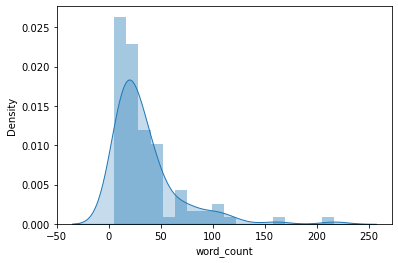

In [ ]:
## count
import seaborn as sns
dtf_train['word_count'] = dtf_train["text_clean"].apply(lambda x: len(nltk.word_tokenize(str(x))) )
## plot
sns.distplot(dtf_train["word_count"], hist=True, kde=True, kde_kws={"shade":True})

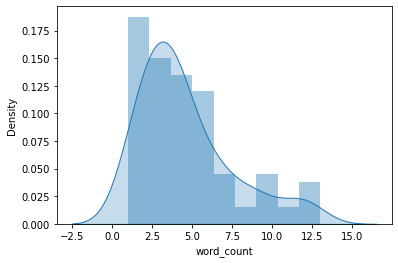

In [ ]:
## count
import seaborn as sns
dtf_train['word_count'] = dtf_train["Summary"].apply(lambda x: len(nltk.word_tokenize(str(x))) )
## plot
sns.distplot(dtf_train["word_count"], hist=True, kde=True, kde_kws={"shade":True})

In [ ]:
X_len = 40
y_len = 4

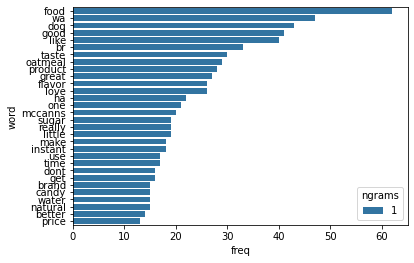

In [ ]:
lst_tokens = nltk.tokenize.word_tokenize(dtf_train["text_clean"].str.cat(sep=" "))
ngrams = [1]
    
## calculate
dtf_freq = pd.DataFrame()
for n in ngrams:
   dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
   dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=
                        ["word","freq"])
   dtf_n["ngrams"] = n
   dtf_freq = dtf_freq.append(dtf_n)
   dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
   dtf_freq_X= dtf_freq.sort_values(["ngrams","freq"], ascending=
                         [True,False])
    
## plot
sns.barplot(x="freq", y="word", hue="ngrams", dodge=False,
 data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30))
plt.show()

In [ ]:
## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [ ]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
data=pd.read_csv("rev100.csv")

In [ ]:
data.drop_duplicates(subset=['text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
data['text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [ ]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['text']:
    cleaned_text.append(text_cleaner(t))


In [ ]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [ ]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

In [ ]:
max_len_text=40 
max_len_summary=4

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [ ]:
from keras import backend as K 
from attention import AttentionLayer
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
Attention layer attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


In [ ]:

from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

used eating flaxseed brownie hodson mill brownies super easy make taste great since like dark chocolate usually add a little bit of cocoa

**Original** summary: delicious brownie

Predicted summary: best brownie mix

In [ ]:
!jupyter nbconvert --to pdf /content/Text\ Preprocessing\ and\ Modeling.ipynb

[NbConvertApp] WARNING | pattern '/content/Text Preprocessing and Modeling.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.a

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-plain-generic is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
!pwd

/content


In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

!jupyter nbconvert --to pdf Text_Summarization.ipynb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-generic-recommended is already the newest version (2017.20180305-1).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
[NbConvertApp] WARNING | pattern 'Text_Summarization.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Appli

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Selecting previously unselected package texlive.
(Reading database ... 182395 files and directories currently installed.)
Preparing to unpack .../texlive_2017.20180305-1_all.deb ...
Unpacking texlive (2017.20180305-1) ...
Setting up texlive (2017.20180305-1) ...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pypandoc: filename=pypandoc-1.7.4-py2.py3-none-any.whl size=32102 sha256=535179eaf5aa11ddd26e01216c49f2fc41a2190d6ffe18d1c8eb9ad71e3a9426
  Stored in directory: /root/.cache/pip/wheels/f1/80/ba/d10ff9f1ebfd8386979b7d86b7e8ed055aa8bc8f4900bfc986
Successfully built pypandoc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/My Drive/Text_Summarization.ipynb ./

cp: cannot stat 'drive/My': No such file or directory
cp: cannot stat 'Drive/Text_Summarization.ipynb': No such file or directory
